In [9]:
import pandas as pd


level = 0
datasets = pd.read_parquet(f'sarima_level{level}.parquet')
distr = datasets[['id', 'distr']].drop_duplicates()

errors = pd.read_parquet('errors.parquet')
performance = pd.read_parquet('performance.parquet')
features = pd.read_parquet('features.parquet')

In [14]:
performance = performance.merge(distr, on='id', how='left')

# Prediction intervals

In [18]:
pd.pivot_table(data=performance, columns='distr', index='model_details', aggfunc='mean', values='pi')

distr,normal,tstud_finite
model_details,,
RF,0.466154,0.576264
"SARIMA(0,0,0)(1,0,0)7",0.792418,0.909560
"SARIMA(1,0,0)(0,0,0)0",0.782857,0.903077


<AxesSubplot:title={'center':'pi'}, xlabel='model_details'>

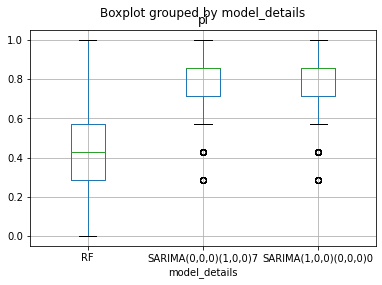

In [16]:
performance[performance['distr']=='normal'].boxplot(column='pi', by='model_details')

<AxesSubplot:title={'center':'pi'}, xlabel='model_details'>

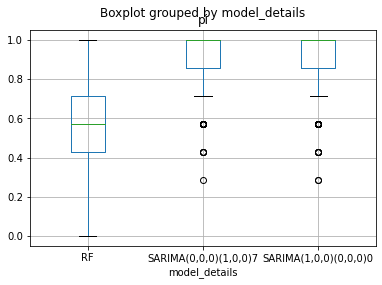

In [17]:
performance[performance['distr']=='tstud_finite'].boxplot(column='pi', by='model_details')

In [6]:
performance.head()

,mape,pi,fold,n,model,id,model_details
index,,,,,,,
0,1.405715,0.571429,12,714,SARIMAXTimeSeriesModel,0,"SARIMA(0,0,0)(1,0,0)7"
1,0.563950,0.714286,11,654,SARIMAXTimeSeriesModel,0,"SARIMA(0,0,0)(1,0,0)7"
2,1.551108,0.571429,10,594,SARIMAXTimeSeriesModel,0,"SARIMA(0,0,0)(1,0,0)7"
3,0.952770,0.857143,9,534,SARIMAXTimeSeriesModel,0,"SARIMA(0,0,0)(1,0,0)7"
4,0.679981,0.857143,8,474,SARIMAXTimeSeriesModel,0,"SARIMA(0,0,0)(1,0,0)7"


In [7]:
features.head()

,feature,impact,fold,model,n,id,model_details
index,,,,,,,
0,ar.S.L7,0.697001,12,SARIMAXTimeSeriesModel,714,0,"SARIMA(0,0,0)(1,0,0)7"
1,sigma2,1.720989,12,SARIMAXTimeSeriesModel,714,0,"SARIMA(0,0,0)(1,0,0)7"
0,ar.S.L7,0.684885,11,SARIMAXTimeSeriesModel,654,0,"SARIMA(0,0,0)(1,0,0)7"
1,sigma2,1.767289,11,SARIMAXTimeSeriesModel,654,0,"SARIMA(0,0,0)(1,0,0)7"
0,ar.S.L7,0.691048,10,SARIMAXTimeSeriesModel,594,0,"SARIMA(0,0,0)(1,0,0)7"


# Parameters

In [21]:
features = features.merge(distr, on='id', how='left')

In [22]:
features.head()

,feature,impact,fold,model,n,id,model_details,distr
0,ar.S.L7,0.697001,12,SARIMAXTimeSeriesModel,714,0,"SARIMA(0,0,0)(1,0,0)7",normal
1,sigma2,1.720989,12,SARIMAXTimeSeriesModel,714,0,"SARIMA(0,0,0)(1,0,0)7",normal
2,ar.S.L7,0.684885,11,SARIMAXTimeSeriesModel,654,0,"SARIMA(0,0,0)(1,0,0)7",normal
3,sigma2,1.767289,11,SARIMAXTimeSeriesModel,654,0,"SARIMA(0,0,0)(1,0,0)7",normal
4,ar.S.L7,0.691048,10,SARIMAXTimeSeriesModel,594,0,"SARIMA(0,0,0)(1,0,0)7",normal


In [24]:
pd.pivot_table(data=features, columns=['distr'], index=['model_details', 'feature'], aggfunc='mean', values='impact')

distr                            normal  tstud_finite
model_details         feature                        
RF                    lag      1.000000      1.000000
SARIMA(0,0,0)(1,0,0)7 ar.S.L7  0.682227      0.685177
                      sigma2   1.869948      7.710110
SARIMA(1,0,0)(0,0,0)0 ar.L1    0.002465     -0.000962
                      ar.L2   -0.007398     -0.001968
                      ar.L3   -0.003867     -0.002735
                      ar.L4   -0.000616      0.004591
                      ar.L5   -0.007451     -0.003515
                      ar.L6   -0.001993     -0.006434
                      ar.L7    0.666004      0.671125
                      sigma2   1.823479      7.583943

In [28]:
import math
DEGREES = 2.1
DEGREES/(DEGREES-2)

20.999999999999982

In [ ]:
import numpy as np

numpy.quantile